In [179]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [180]:
IMAGE_SIZE = 512
BATCH_SIZE = 2
NUM_CLASSES = 20
DATA_DIR = "D:\\Study\\Segmentation\\instance-level-human-parsing\\instance-level_human_parsing\\instance-level_human_parsing\\Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [181]:
train_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[:NUM_TRAIN_IMAGES]#1000
train_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[:NUM_TRAIN_IMAGES]#1000

val_images = sorted(glob(os.path.join(DATA_DIR, 'Images/*')))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]#1000
val_masks = sorted(glob(os.path.join(DATA_DIR, 'Category_ids/*')))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]#1000

In [182]:
def read_image(image_path, mask = False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels = 1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images = image, size = [IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels = 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images = image, size = [IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1 # Normalization -1 ~ 1
    
    return image

In [183]:
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask = True)
    return image, mask

In [184]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [185]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset : ", train_dataset)
print("Val Dataset : ", val_dataset)

Train Dataset :  <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset :  <BatchDataset shapes: ((2, 512, 512, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


In [186]:
def convolution_block(block_input, num_filters=256, kernel_size = 3,
                      dilation_rate = 1, padding = 'same', use_bias = False):
    x = layers.Conv2D(num_filters, kernel_size = kernel_size,
                      dilation_rate=dilation_rate, padding = 'same',
                      use_bias=use_bias, kernel_initializer = keras.initializers.HeNormal())(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [187]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size = (dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size = 1, use_bias = True)
    out_pool = layers.UpSampling2D(size = (dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
                                   interpolation='bilinear')(x)
    
    out_1 = convolution_block(dspp_input, kernel_size = 1, dilation_rate = 1)
    out_6 = convolution_block(dspp_input, kernel_size = 3, dilation_rate = 6)
    out_12 = convolution_block(dspp_input, kernel_size = 3, dilation_rate = 12)
    out_18 = convolution_block(dspp_input, kernel_size = 3, dilation_rate = 18)
    
    x = layers.Concatenate(axis = -1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size = 1)
    return output

In [188]:
def DeeplabV3(image_size, num_classes):
    model_input = keras.Input(shape = (image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(weights='imagenet', include_top = False, input_tensor = model_input)
    
    x = resnet50.get_layer('conv4_block6_2_relu').output
    x = DilatedSpatialPyramidPooling(x)
    
    input_a = layers.UpSampling2D(size = (image_size // 4 // x.shape[1],
                                          image_size // 4 // x.shape[2]),
                                  interpolation='bilinear')(x)
    
    input_b = resnet50.get_layer('conv2_block3_2_relu').output
    input_b = convolution_block(input_b, num_filters = 48, kernel_size = 1)
    
    x = layers.Concatenate(axis = -1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(size = (image_size // x.shape[1],
                                    image_size // x.shape[2]),
                            interpolation='bilinear')(x)
    model_output = layers.Conv2D(num_classes , kernel_size = (1, 1), padding = 'same')(x)
    return keras.Model(inputs = model_input, outputs = model_output)

model = DeeplabV3(image_size = IMAGE_SIZE, num_classes = NUM_CLASSES)
model.summary()

Model: "model_45"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_47[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [189]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = loss, metrics = ['accuracy'])

history = model.fit(train_dataset, validation_data = val_dataset, epochs = 20)



Epoch 1/20
500/500 [==============================] - 71s 135ms/step - loss: 1.2429 - accuracy: 0.6247 - val_loss: 2.1175 - val_accuracy: 0.5953
Epoch 2/20
500/500 [==============================] - 67s 134ms/step - loss: 1.0246 - accuracy: 0.6800 - val_loss: 1.2597 - val_accuracy: 0.6109
Epoch 3/20
500/500 [==============================] - 66s 131ms/step - loss: 0.9180 - accuracy: 0.7097 - val_loss: 0.9787 - val_accuracy: 0.7042
Epoch 4/20
500/500 [==============================] - 66s 131ms/step - loss: 0.8437 - accuracy: 0.7320 - val_loss: 0.9880 - val_accuracy: 0.6884
Epoch 5/20
500/500 [==============================] - 66s 132ms/step - loss: 0.7757 - accuracy: 0.7517 - val_loss: 0.8912 - val_accuracy: 0.7188
Epoch 6/20
500/500 [==============================] - 66s 132ms/step - loss: 0.7288 - accuracy: 0.7655 - val_loss: 0.8710 - val_accuracy: 0.7306
Epoch 7/20
500/500 [==============================] - 66s 132ms/step - loss: 0.6859 - accuracy: 0.7792 - val_loss: 0.8726 - val_ac

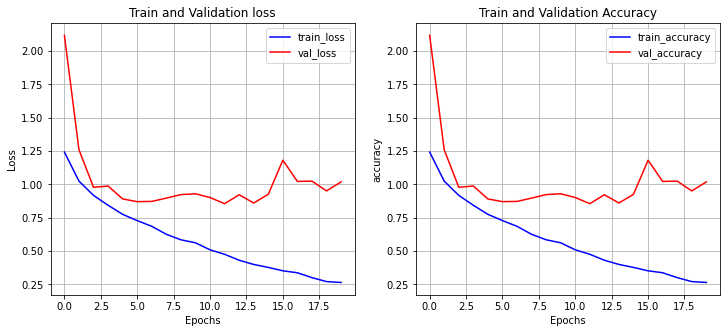

In [190]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(loss, color = 'blue', label = 'train_loss')
ax1.plot(val_loss, color = 'red', label = 'val_loss')
ax1.set_title('Train and Validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history.history['loss']
val_accuracy = history.history['val_loss']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(loss, color = 'blue', label = 'train_accuracy')
ax2.plot(val_loss, color = 'red', label = 'val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()

In [191]:
colormap = loadmat('D:\\Study\\Segmentation\\instance-level-human-parsing\\instance-level_human_parsing\\instance-level_human_parsing\\human_colormap.mat')['colormap']
colormap = colormap * 100
colormap = colormap.astype(np.uint8)

In [192]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis = 0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis = 2)
    return predictions

In [193]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for i in range(0, n_classes):
        idx = mask == i
        r[idx] = colormap[i, 0]
        g[idx] = colormap[i, 1]
        b[idx] = colormap[i, 2]
    rgb = np.stack([r, g, b], axis = 2)
    return rgb

In [194]:
def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

In [195]:
def plot_samples_matplotlib(display_list, figsize = (5, 3)):
    _, axes = plt.subplots(nrows =1, ncols = len(display_list), figsize = figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

In [196]:
def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor = image_tensor, model = model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib([image_tensor, overlay, prediction_colormap], figsize = (18, 14))

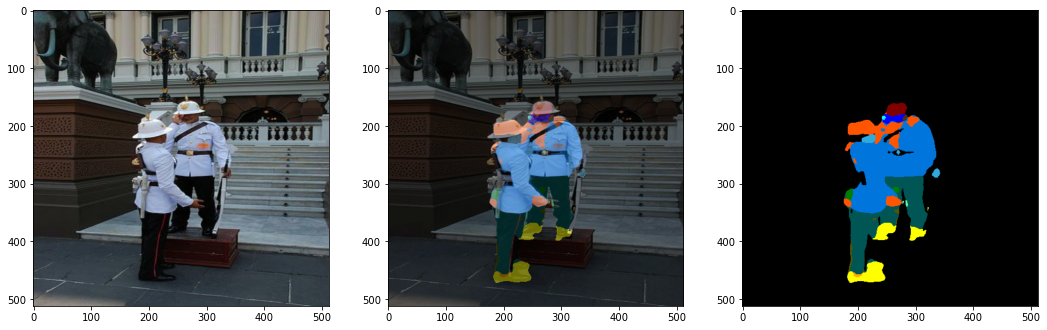

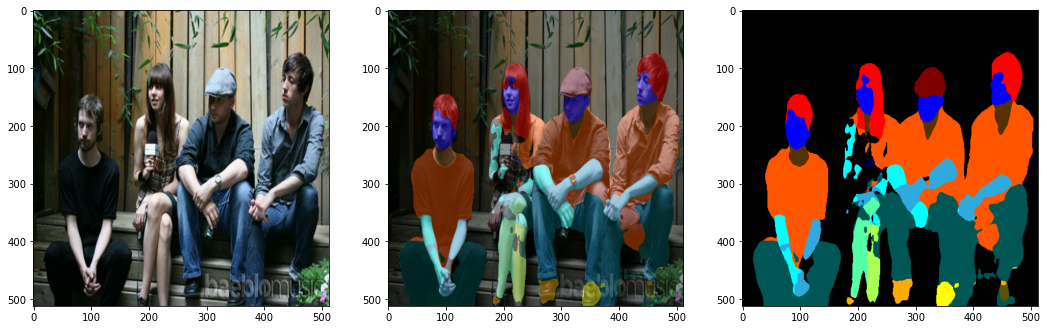

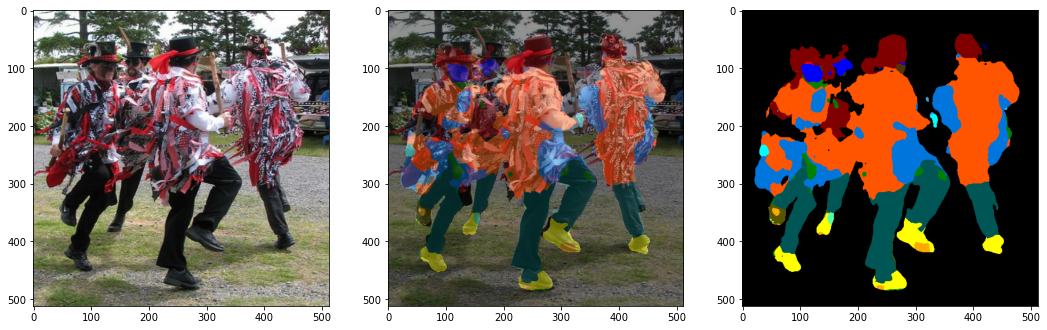

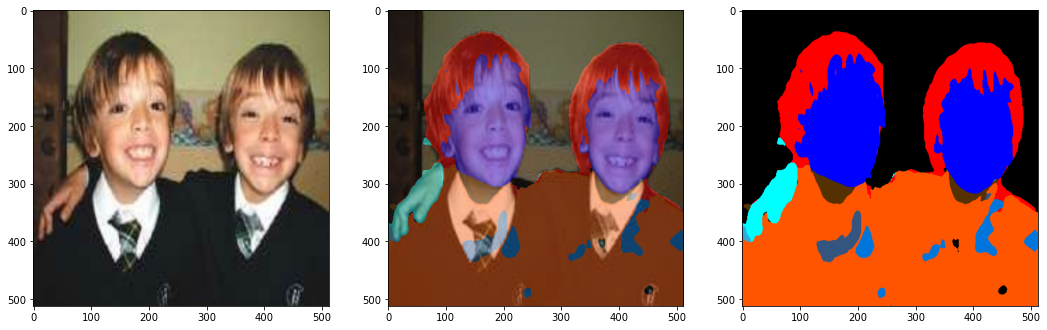

In [198]:
plot_predictions(train_images[:4], colormap, model = model)

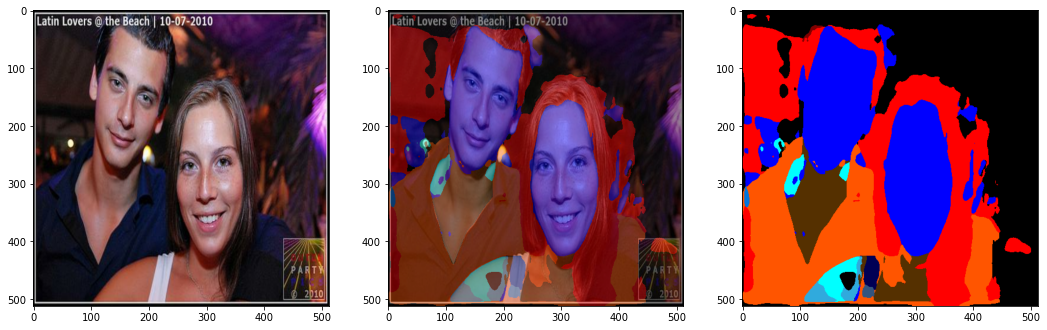

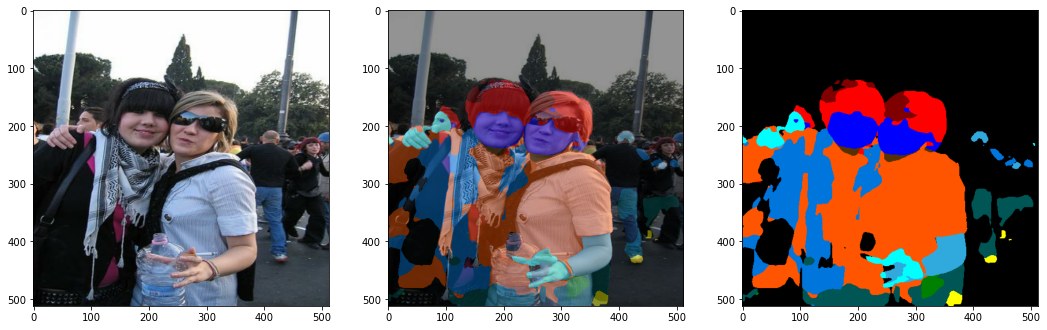

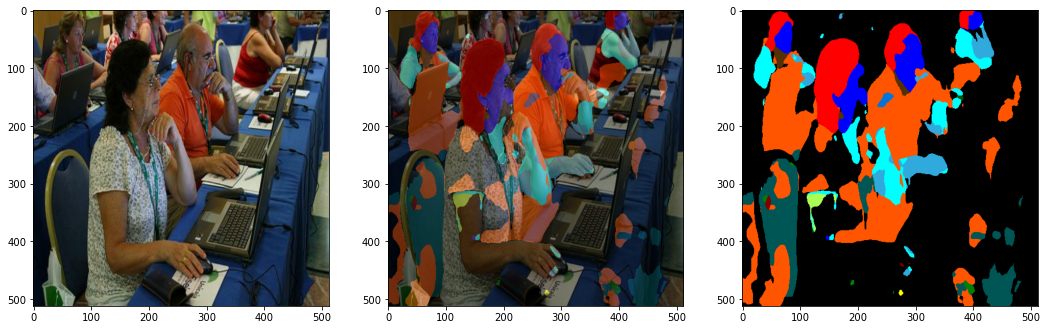

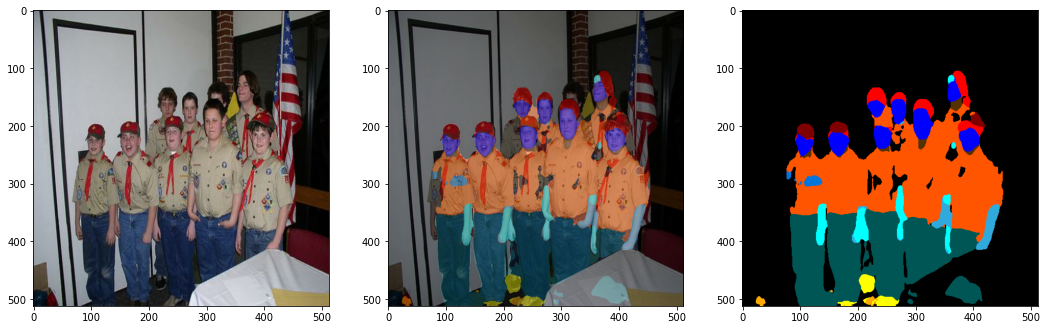

In [199]:
plot_predictions(val_images[:4], colormap, model = model)